# Medical Image Classification with MONAI

In [37]:
from tqdm import tqdm
import numpy as np
import os
import PIL
import shutil
import tempfile
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import classification_report

import medmnist
from medmnist import INFO, Evaluator

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader, Dataset
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121, resnet18
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    EnsureChannelFirst,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity, 
    Transform,
    ToTensor,
    EnsureType,
)
from monai.utils import set_determinism

print_config()

MONAI version: 1.4.dev2441
Numpy version: 1.26.3
Pytorch version: 2.2.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: cf815ed4e44a5b8ce67e894ab0bc2765279a1a59
MONAI __file__: /mnt/hdd/<username>/.local/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: 0.24.0
scipy version: 1.14.1
Pillow version: 10.2.0
Tensorboard version: 2.18.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.17.1
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 2.2.3
einops version: 0.8.0
transformers version: 4.45.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the o

## Continue working with OrganMNIST3d 64x64x64

In [2]:
data_flag = 'organmnist3d'
download = True

NUM_EPOCHS = 100
BATCH_SIZE = 32
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', download=download, size=64)
val_dataset = DataClass(split='val', download=download, size=64)
test_dataset = DataClass(split='test', download=download, size=64)

Using downloaded and verified file: /mnt/hdd/marina/.medmnist/organmnist3d_64.npz
Using downloaded and verified file: /mnt/hdd/marina/.medmnist/organmnist3d_64.npz
Using downloaded and verified file: /mnt/hdd/marina/.medmnist/organmnist3d_64.npz


In [3]:
root_dir = '/mnt/hdd/marina/.medmnist/'

In [4]:
train_dataset

Dataset OrganMNIST3D of size 64 (organmnist3d_64)
    Number of datapoints: 971
    Root location: /mnt/hdd/marina/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'liver', '1': 'kidney-right', '2': 'kidney-left', '3': 'femur-right', '4': 'femur-left', '5': 'bladder', '6': 'heart', '7': 'lung-right', '8': 'lung-left', '9': 'spleen', '10': 'pancreas'}
    Number of samples: {'train': 971, 'val': 161, 'test': 610}
    Description: The source of the OrganMNIST3D is the same as that of the Organ{A,C,S}MNIST. Instead of 2D images, we directly use the 3D bounding boxes and process the images into 28×28×28 to perform multi-class classification of 11 body organs. The same 115 and 16 CT scans as the Organ{A,C,S}MNIST from the source training set are used as training and validation set, respectively, and the same 70 CT scans as the Organ{A,C,S}MNIST from the source test set are treated as the test set.
    License: CC BY 4.0

## Define transforms

In [5]:
train_transforms = Compose(
    [
        ScaleIntensity(),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        EnsureType(),
    ]
)

val_transforms = Compose([
    ScaleIntensity(),
    ToTensor(),
    EnsureType(),
])

test_transforms = Compose([
    ScaleIntensity(),
    ToTensor(),
    EnsureType(),
])

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=n_classes)])

## Extract 2d slices

In [6]:
class Extract2DSlices(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data, label = self.dataset[idx]

        if self.transform:
            data = self.transform(data)

        axial, coronal, sagittal = self.extract_2d_slices(data)

        data = {'axial': axial, 'coronal': coronal, 'sagittal': sagittal}
        
        return {'images': (data['axial'], data['coronal'], data['sagittal']), 'label': label}

    @staticmethod
    def extract_2d_slices(data):
        axial = data[:, data.shape[1] // 2, :, :]
        coronal = data[:, :, data.shape[2] // 2, :]
        sagittal = data[:, :, :, data.shape[3] // 2]
        return axial, coronal, sagittal

In [7]:
train_dataset_ = Extract2DSlices(train_dataset, transform=train_transforms)
val_dataset_ = Extract2DSlices(val_dataset, transform=val_transforms)
test_dataset_ = Extract2DSlices(test_dataset, transform=test_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset_, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset_, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset_, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
def montage(dataset, length=20, replace=False, save_folder='dataset', flag = 'axial'):
    from medmnist.utils import montage2d

    imgs = []

    n_sel = length * length
    sel = np.random.choice(dataset.__len__(), size=n_sel, replace=replace)
    
    if flag == 'axial':
        slice_ = 0
    elif flag == 'coronal':
        slice_ = 1
    else:
        slice_ = 2
    
    for idx in sel:
        imgs.append((dataset[idx]['images'][slice_]*255).astype(np.uint8))
        
    montage_img = montage2d(np.array(imgs)[:, 0],
                            n_channels=n_channels,
                            sel=range(0, n_sel))
    
    if save_folder is not None:
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)
        montage_img.save(os.path.join(save_folder,
                                        f"{data_flag}{flag}_montage.png"))

    return montage_img

### Slices

In [9]:
idx = np.random.choice(train_dataset_.__len__(), size=10, replace=False)

idx

array([ 78, 199, 497, 847, 149, 306,   6, 588, 405, 247])

In [10]:
def show_slice(dataset, idx):

    fig, axs = plt.subplots(3,10)

    for i, index in enumerate(idx):
        x1, x2, x3 = dataset[index]['images']
        y = dataset[index]['label']

        ax = axs[0, i]
        ax.imshow(x1[0].numpy(), cmap='gray')
        ax.set_title(f'{y}')
        ax.set_xticks([])
        ax.set_yticks([])

        ax = axs[1, i]
        ax.imshow(x2[0].numpy(), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

        ax = axs[2, i]
        ax.imshow(x3[0].numpy(), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

    plt.axis('off')
    plt.figure(figsize=(7,15))
    plt.show()

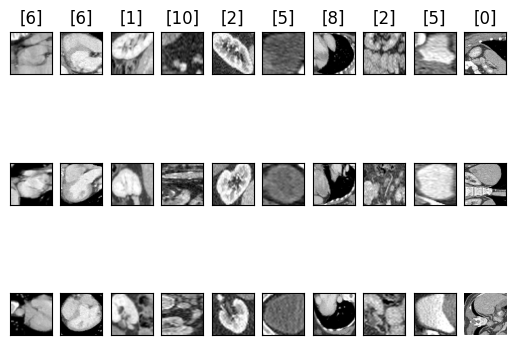

<Figure size 700x1500 with 0 Axes>

In [11]:
show_slice(train_dataset_, idx)

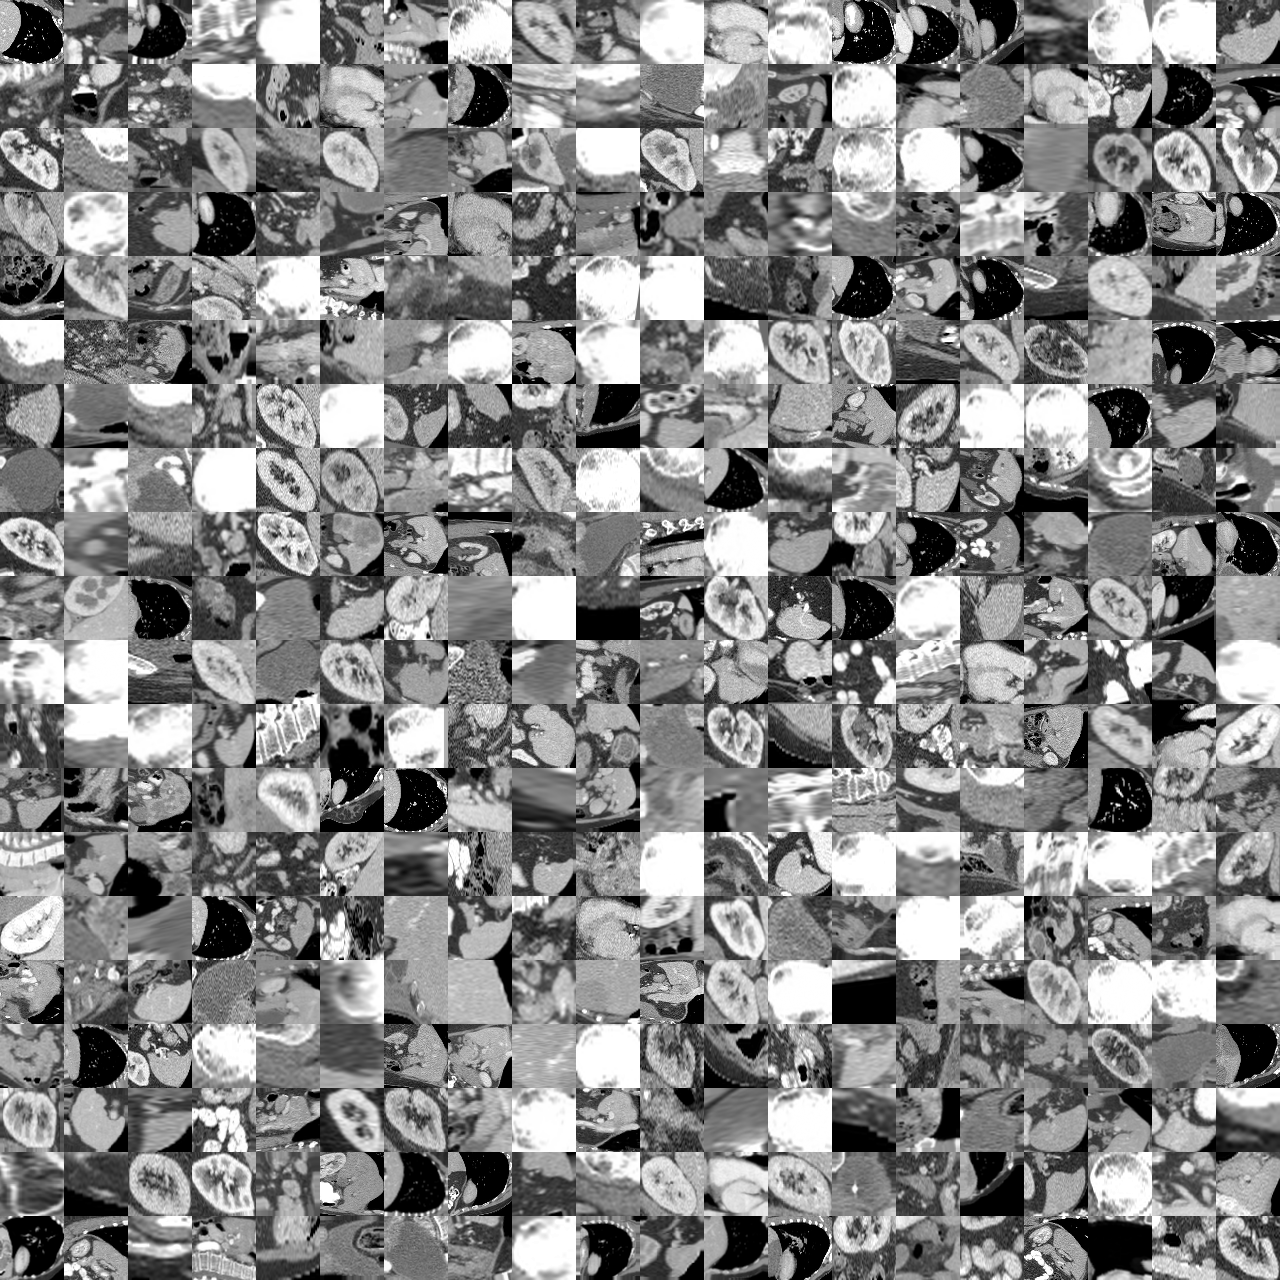

In [12]:
montage(train_dataset_, length=20, replace=False, flag = 'axial')

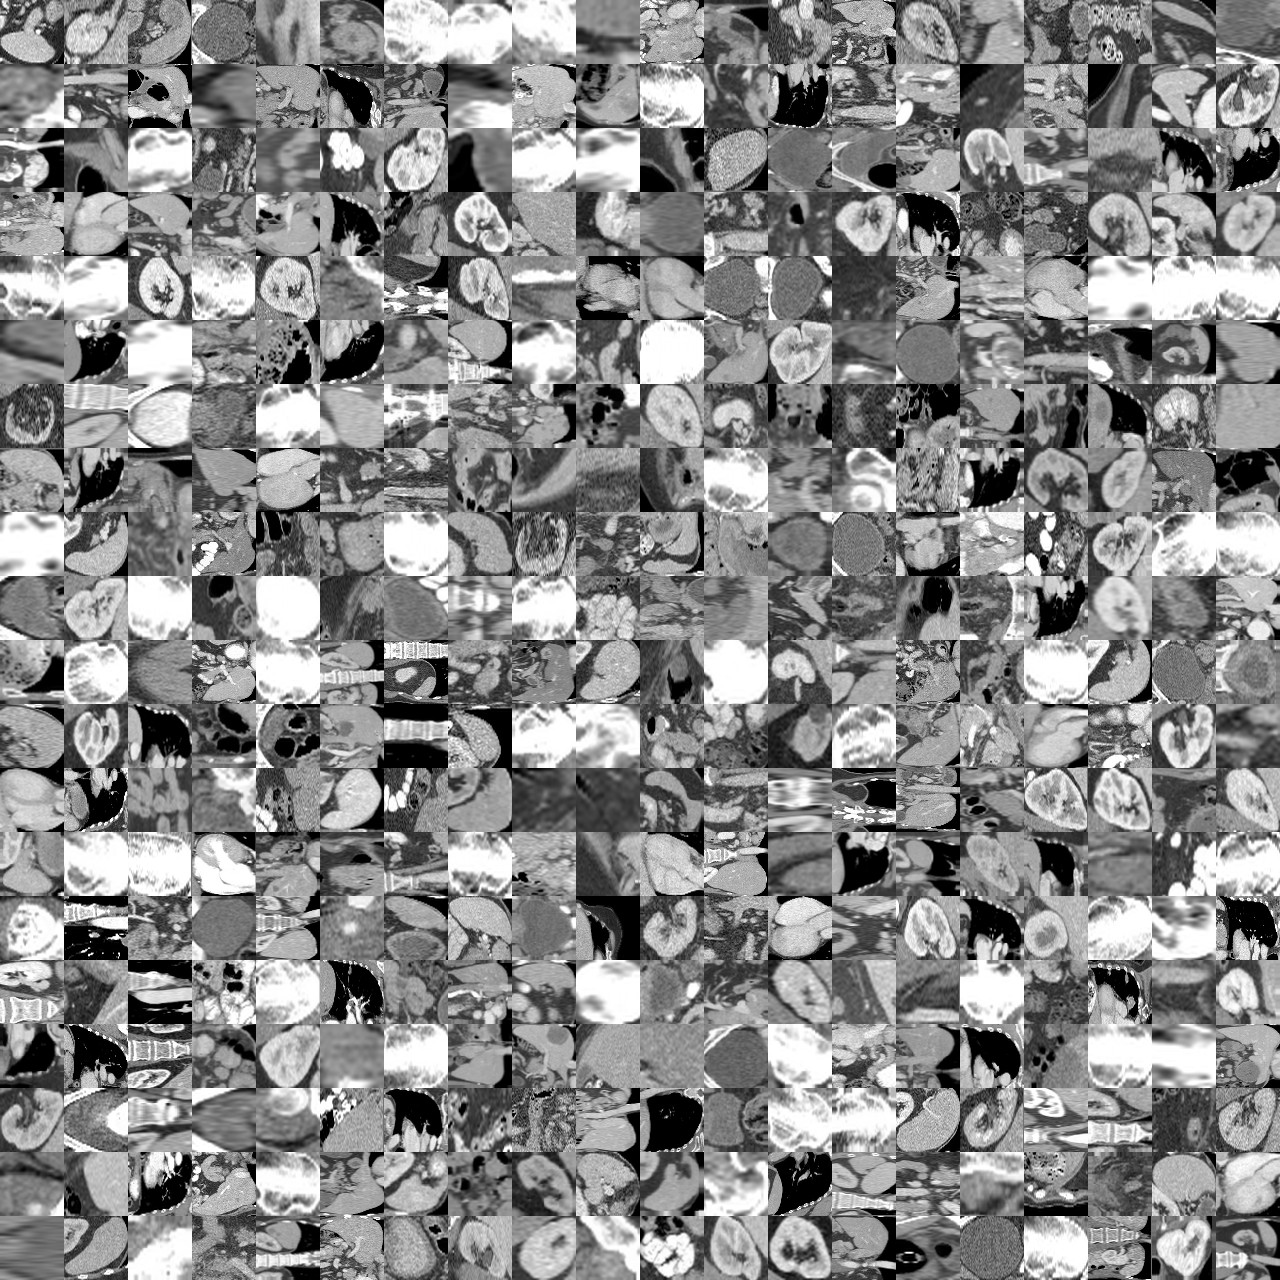

In [13]:
montage(train_dataset_, length=20, replace=False, flag = 'coronal')

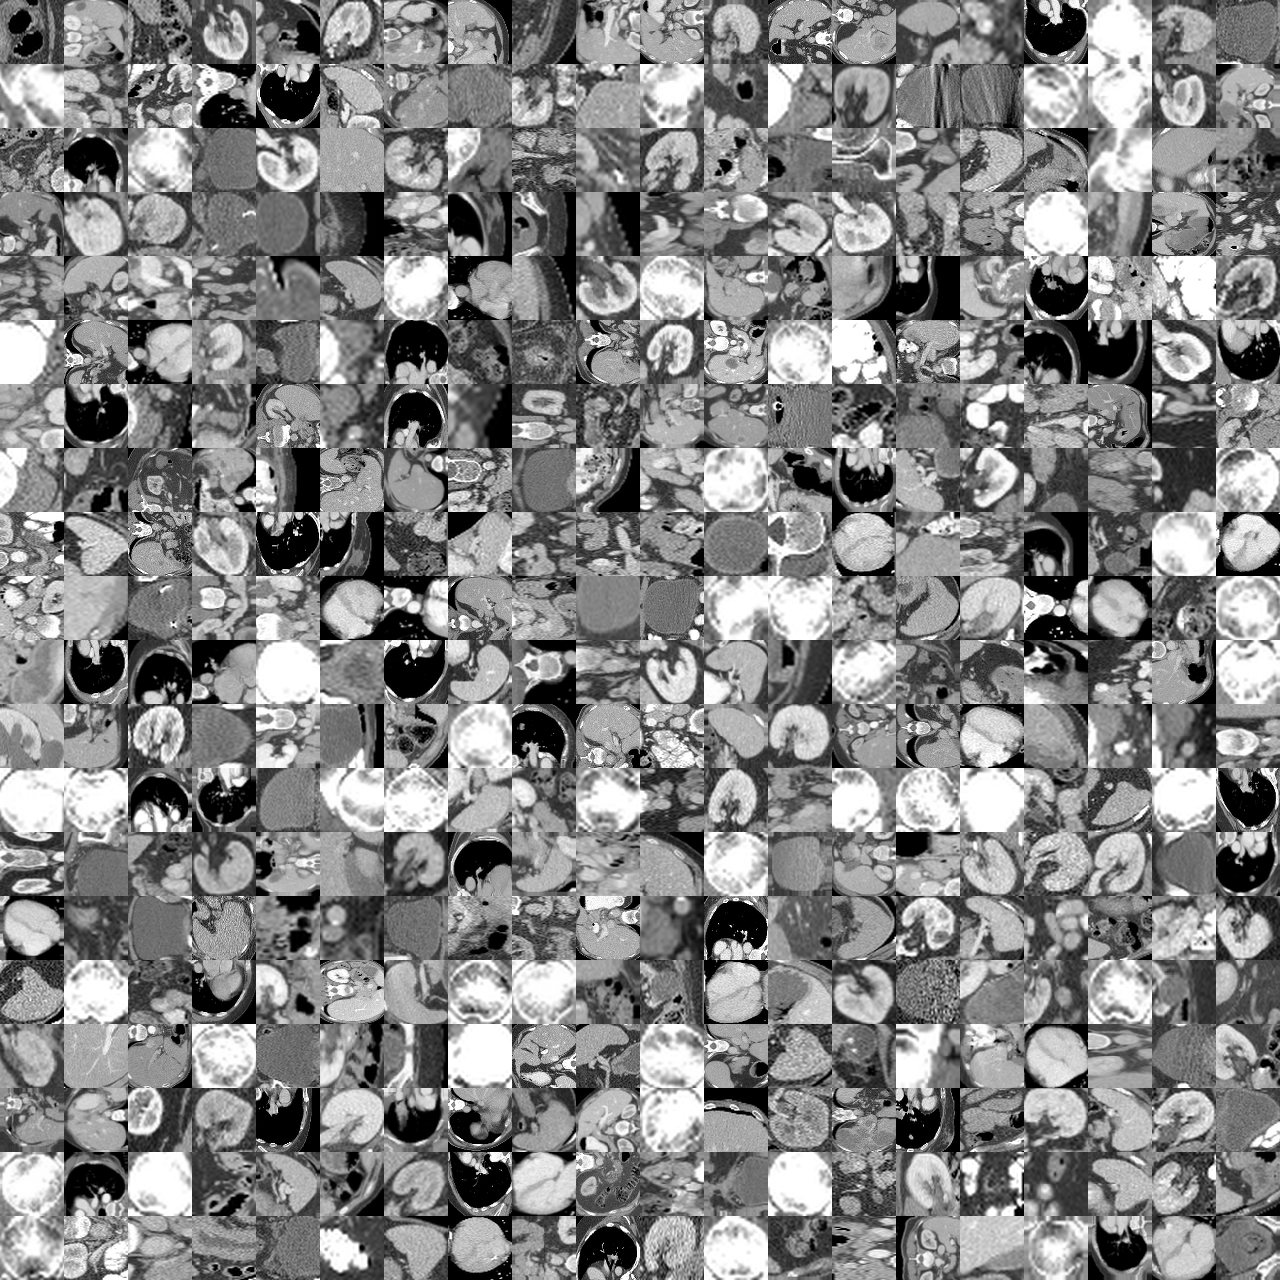

In [14]:
montage(train_dataset_, length=20, replace=False, flag = 'sagittal')

## Training cycle

### Pretrained

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True).to(device)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(resnet18.fc.in_features, n_classes)
model = model.to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 100
val_interval = 1
auc_metric = ROCAUCMetric()

In [48]:
print(model)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [49]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(axial.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_dataset) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_axial.to(device))], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_axial.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/100
1/30, train_loss: 2.8021
2/30, train_loss: 2.6826
3/30, train_loss: 2.6183
4/30, train_loss: 2.5727
5/30, train_loss: 2.8374
6/30, train_loss: 2.3063
7/30, train_loss: 2.4340
8/30, train_loss: 2.2773
9/30, train_loss: 2.4742
10/30, train_loss: 2.3913
11/30, train_loss: 2.0770
12/30, train_loss: 2.3462
13/30, train_loss: 2.0643
14/30, train_loss: 2.0717
15/30, train_loss: 2.0091
16/30, train_loss: 2.2833
17/30, train_loss: 1.9180
18/30, train_loss: 1.9972
19/30, train_loss: 2.2819
20/30, train_loss: 2.0713
21/30, train_loss: 1.7357
22/30, train_loss: 1.9252
23/30, train_loss: 1.9730
24/30, train_loss: 2.2241
25/30, train_loss: 1.8019
26/30, train_loss: 1.7774
27/30, train_loss: 1.8668
28/30, train_loss: 1.6307
29/30, train_loss: 1.6035
30/30, train_loss: 1.5840
31/30, train_loss: 1.3790
epoch 1 average loss: 2.1296
1
saved new best metric model
current epoch: 1 current AUC: 0.6659 current accuracy: 0.1677 best AUC: 0.6659 at epoch: 1
----------
epoch 2/100
1/30, t

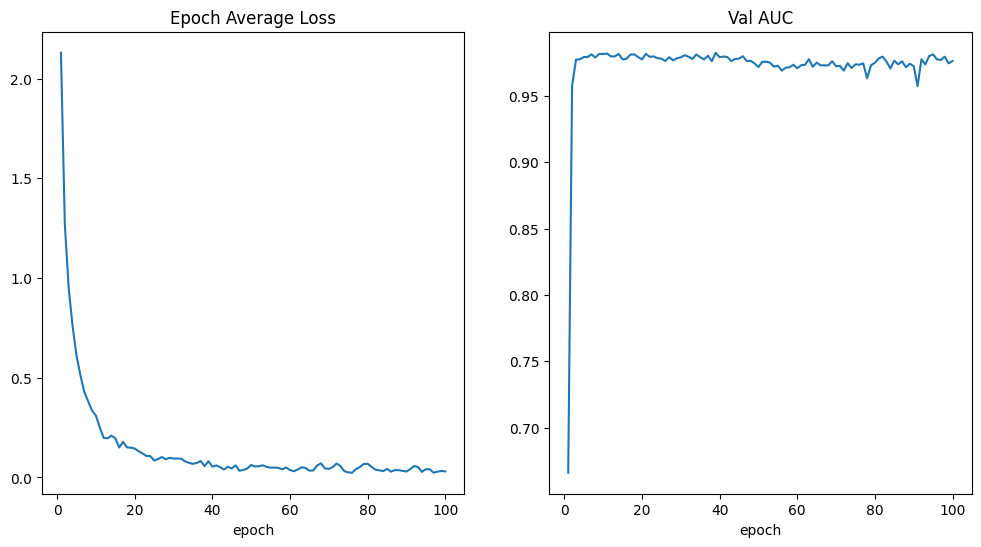

In [50]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluate the model on test dataset

In [51]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_axial.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_axial.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [52]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.8590    0.9710    0.9116        69
           1     0.5217    0.5294    0.5255        68
           2     0.5231    0.4928    0.5075        69
           3     0.5735    0.6000    0.5865        65
           4     0.5472    0.4462    0.4915        65
           5     0.7368    0.8485    0.7887        66
           6     0.8519    0.8214    0.8364        28
           7     0.9524    0.9524    0.9524        21
           8     0.9524    0.9524    0.9524        21
           9     0.7833    0.6812    0.7287        69
          10     0.6250    0.6522    0.6383        69

    accuracy                         0.6820       610
   macro avg     0.7206    0.7225    0.7199       610
weighted avg     0.6776    0.6820    0.6779       610



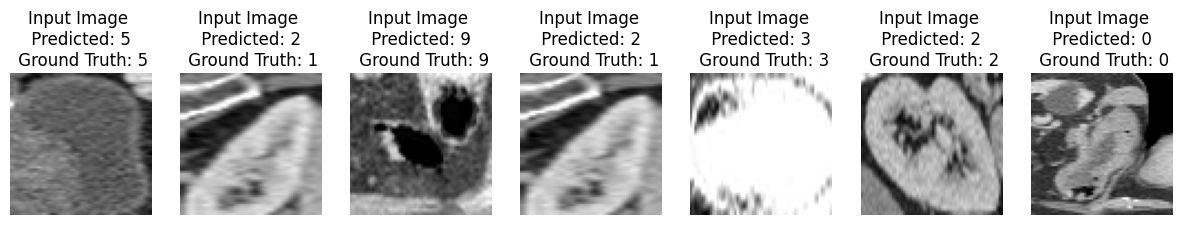

In [53]:
def plot_examples(images, preds, labels, n=5):
    plt.figure(figsize=(15, n))
    for i in range(n):
        j = np.random.randint(0, len(images))
        plt.subplot(1, n, i + 1)
        plt.imshow(images[j].squeeze(), cmap='gray')
        plt.title(f"Input Image \n Predicted: {preds[j]} \n Ground Truth: {labels[j]}")
        plt.axis('off')

    plt.show()

plot_examples(example_axial[1], example_preds[1], example_labels[1], n=7)

### Unpretrained

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 100
val_interval = 1
auc_metric = ROCAUCMetric()

In [16]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(axial.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_dataset) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_axial.to(device))], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_axial.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/100
1/30, train_loss: 2.5422
2/30, train_loss: 2.5312
3/30, train_loss: 2.2830
4/30, train_loss: 2.4634
5/30, train_loss: 2.2468
6/30, train_loss: 2.2319
7/30, train_loss: 1.9288
8/30, train_loss: 2.3147
9/30, train_loss: 2.0171
10/30, train_loss: 1.7228
11/30, train_loss: 2.1727
12/30, train_loss: 2.0768
13/30, train_loss: 1.9951
14/30, train_loss: 2.0778
15/30, train_loss: 1.8641
16/30, train_loss: 2.2428
17/30, train_loss: 1.8609
18/30, train_loss: 1.9885
19/30, train_loss: 1.9578
20/30, train_loss: 1.6583
21/30, train_loss: 1.9120
22/30, train_loss: 1.5732
23/30, train_loss: 1.7658
24/30, train_loss: 1.6086
25/30, train_loss: 1.6854
26/30, train_loss: 1.7127
27/30, train_loss: 1.7313
28/30, train_loss: 1.4844
29/30, train_loss: 2.0573
30/30, train_loss: 1.5968
31/30, train_loss: 1.2411
epoch 1 average loss: 1.9531
1
saved new best metric model
current epoch: 1 current AUC: 0.5993 current accuracy: 0.0932 best AUC: 0.5993 at epoch: 1
----------
epoch 2/100
1/30, t

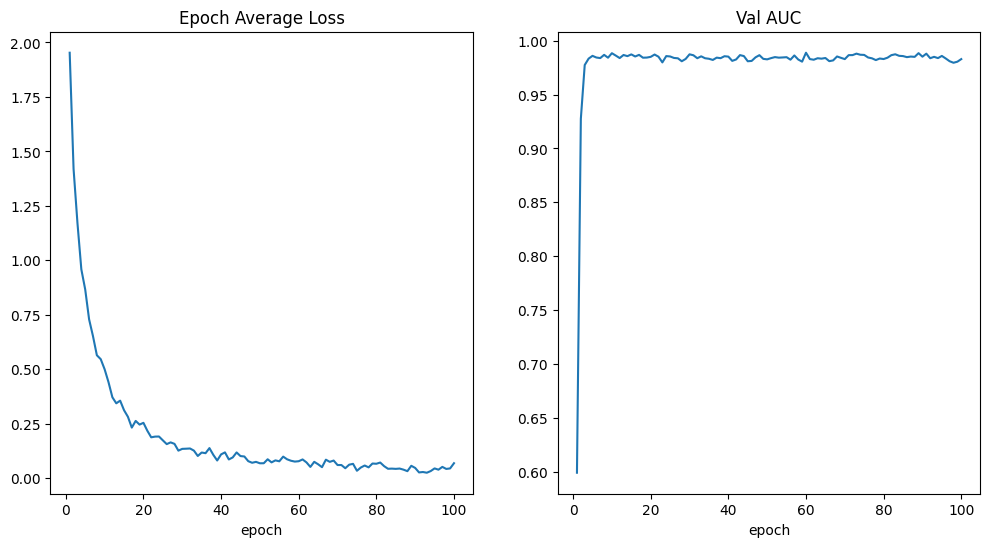

In [17]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluate the model on test dataset

In [30]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_axial.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_axial.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [31]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.8101    0.9275    0.8649        69
           1     0.6034    0.5147    0.5556        68
           2     0.5645    0.5072    0.5344        69
           3     0.4808    0.3846    0.4274        65
           4     0.4928    0.5231    0.5075        65
           5     0.7403    0.8636    0.7972        66
           6     0.7931    0.8214    0.8070        28
           7     1.0000    1.0000    1.0000        21
           8     0.9545    1.0000    0.9767        21
           9     0.7231    0.6812    0.7015        69
          10     0.7368    0.8116    0.7724        69

    accuracy                         0.6852       610
   macro avg     0.7181    0.7305    0.7222       610
weighted avg     0.6754    0.6852    0.6779       610



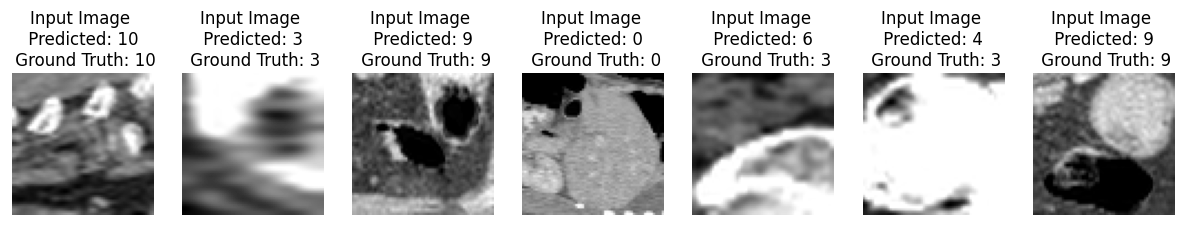

In [34]:
def plot_examples(images, preds, labels, n=5):
    plt.figure(figsize=(15, n))
    for i in range(n):
        j = np.random.randint(0, len(images))
        plt.subplot(1, n, i + 1)
        plt.imshow(images[j].squeeze(), cmap='gray')
        plt.title(f"Input Image \n Predicted: {preds[j]} \n Ground Truth: {labels[j]}")
        plt.axis('off')

    plt.show()

plot_examples(example_axial[1], example_preds[1], example_labels[1], n=7)

## Let's repeat the process for coronnal and sagittal parts of the dataset

### Training cycle for the coronal part

In [153]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 100
val_interval = 1
auc_metric = ROCAUCMetric()

In [154]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(coronal.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_dataset) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_coronal.to(device))], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_coronal.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/100
1/30, train_loss: 2.4312
2/30, train_loss: 2.4450
3/30, train_loss: 2.2877
4/30, train_loss: 2.2485
5/30, train_loss: 2.2717
6/30, train_loss: 2.2706
7/30, train_loss: 2.0986
8/30, train_loss: 2.3035
9/30, train_loss: 2.0530
10/30, train_loss: 1.9474
11/30, train_loss: 2.1249
12/30, train_loss: 2.0385
13/30, train_loss: 2.0212
14/30, train_loss: 1.9737
15/30, train_loss: 1.9833
16/30, train_loss: 1.9587
17/30, train_loss: 1.9418
18/30, train_loss: 1.7681
19/30, train_loss: 1.9478
20/30, train_loss: 1.9529
21/30, train_loss: 1.7706
22/30, train_loss: 1.7494
23/30, train_loss: 1.8908
24/30, train_loss: 1.7828
25/30, train_loss: 1.6265
26/30, train_loss: 1.7043
27/30, train_loss: 1.7132
28/30, train_loss: 1.5724
29/30, train_loss: 1.6979
30/30, train_loss: 1.4664
31/30, train_loss: 1.8248
epoch 1 average loss: 1.9634
1
saved new best metric model
current epoch: 1 current AUC: 0.6203 current accuracy: 0.0932 best AUC: 0.6203 at epoch: 1
----------
epoch 2/100
1/30, t

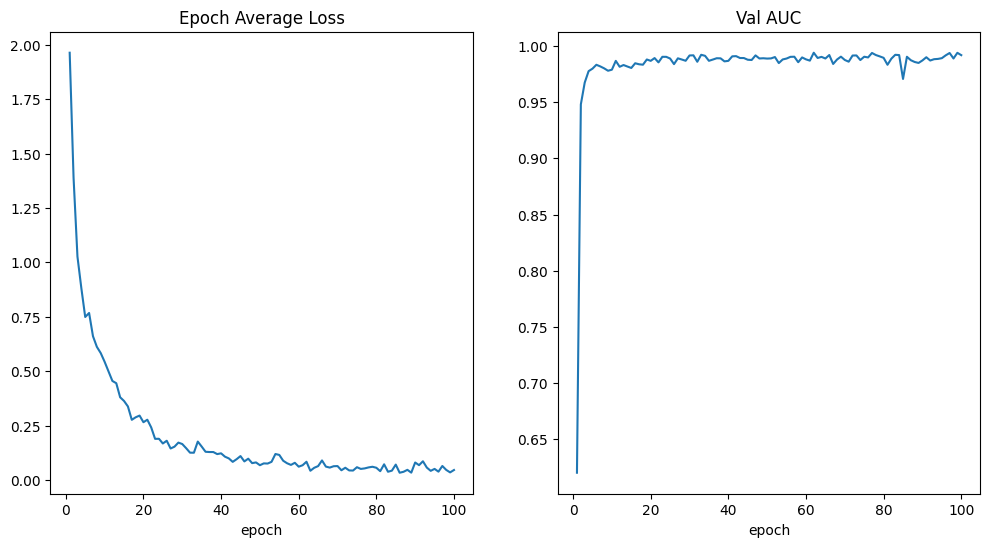

In [155]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluate the model on test dataset

In [156]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_coronal.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_axial.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [157]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.8333    0.7971    0.8148        69
           1     0.4935    0.5588    0.5241        68
           2     0.4000    0.3768    0.3881        69
           3     0.4205    0.5692    0.4837        65
           4     0.4211    0.3692    0.3934        65
           5     0.7222    0.7879    0.7536        66
           6     0.7857    0.3929    0.5238        28
           7     0.9412    0.7619    0.8421        21
           8     0.7391    0.8095    0.7727        21
           9     0.6667    0.4348    0.5263        69
          10     0.4070    0.5072    0.4516        69

    accuracy                         0.5590       610
   macro avg     0.6209    0.5787    0.5886       610
weighted avg     0.5777    0.5590    0.5597       610



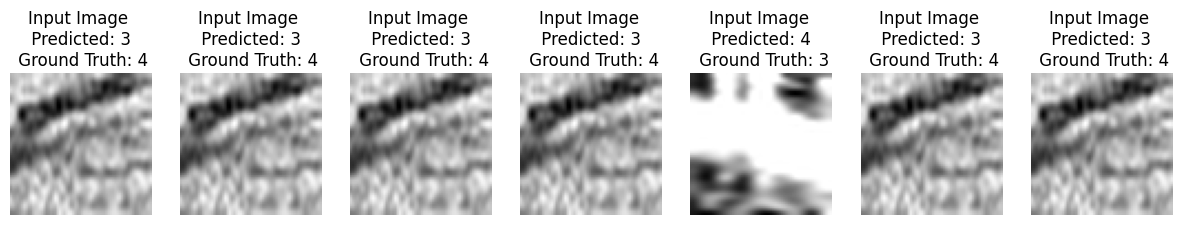

In [158]:
plot_examples(test_coronal, pred, test_labels, n=7)

### Training cycle for the sagittal part

In [159]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 100
val_interval = 1
auc_metric = ROCAUCMetric()

In [160]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(sagittal.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_dataset) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_sagittal.to(device))], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_sagittal.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/100
1/30, train_loss: 2.4915
2/30, train_loss: 2.5787
3/30, train_loss: 2.3627
4/30, train_loss: 2.2841
5/30, train_loss: 2.2857
6/30, train_loss: 2.1823
7/30, train_loss: 2.2769
8/30, train_loss: 2.2444
9/30, train_loss: 2.0814
10/30, train_loss: 1.9607
11/30, train_loss: 2.0000
12/30, train_loss: 1.9431
13/30, train_loss: 1.8520
14/30, train_loss: 1.9218
15/30, train_loss: 1.9873
16/30, train_loss: 1.9232
17/30, train_loss: 1.7934
18/30, train_loss: 1.9290
19/30, train_loss: 1.8393
20/30, train_loss: 1.6464
21/30, train_loss: 1.6286
22/30, train_loss: 1.7832
23/30, train_loss: 1.9806
24/30, train_loss: 2.0242
25/30, train_loss: 1.7761
26/30, train_loss: 1.5896
27/30, train_loss: 1.6373
28/30, train_loss: 1.7670
29/30, train_loss: 1.6920
30/30, train_loss: 1.6962
31/30, train_loss: 1.7871
epoch 1 average loss: 1.9660
1
saved new best metric model
current epoch: 1 current AUC: 0.5921 current accuracy: 0.0932 best AUC: 0.5921 at epoch: 1
----------
epoch 2/100
1/30, t

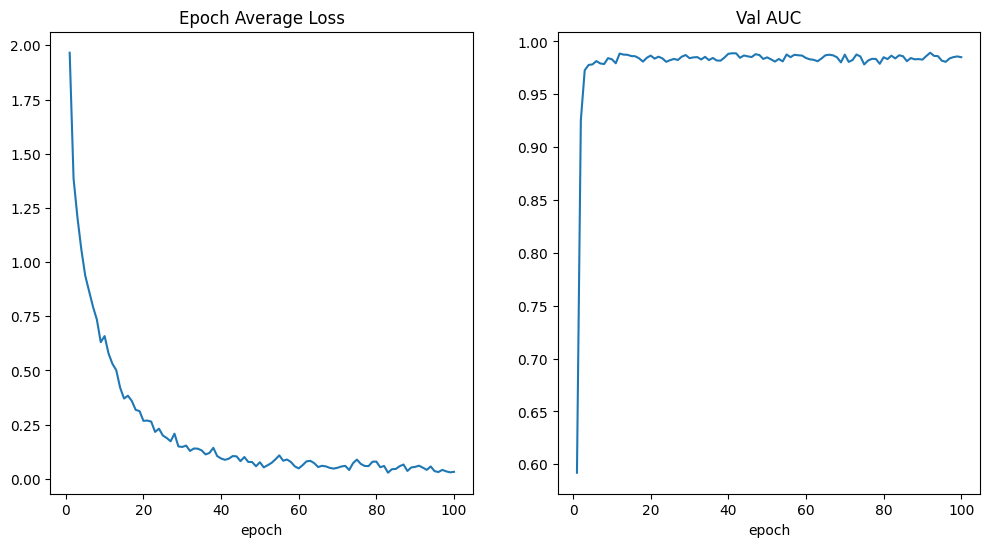

In [161]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluate the model on test dataset

In [162]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_sagittal.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_axial.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [163]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.6190    0.1884    0.2889        69
           1     0.2143    0.2647    0.2368        68
           2     0.2366    0.3188    0.2716        69
           3     0.5000    0.4615    0.4800        65
           4     0.4839    0.2308    0.3125        65
           5     0.5696    0.6818    0.6207        66
           6     0.5556    0.1786    0.2703        28
           7     0.3750    0.2857    0.3243        21
           8     0.3333    0.1429    0.2000        21
           9     0.3396    0.5217    0.4114        69
          10     0.2745    0.4058    0.3275        69

    accuracy                         0.3623       610
   macro avg     0.4092    0.3346    0.3404       610
weighted avg     0.4065    0.3623    0.3554       610



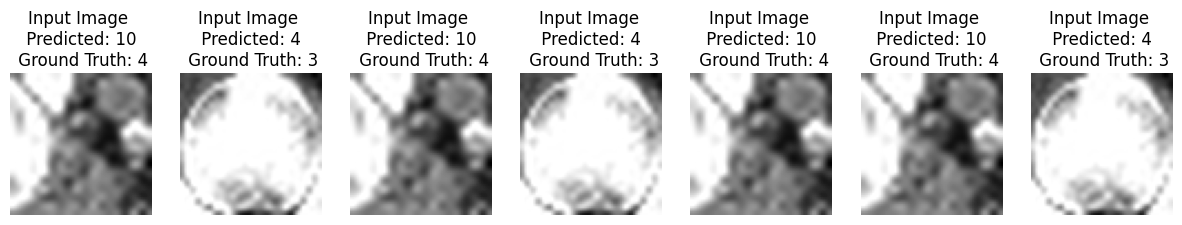

In [164]:
plot_examples(test_sagittal, pred, test_labels, n=7)

## Use 2d models as a backbone

In [165]:
# Load the pretrained models for each slice direction
model_axial = resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)
model_coronal = resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)
model_sagittal = resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)

# Load the trained weights for each model
model_axial.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_axial.pth"), weights_only=True))
model_coronal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_coronal.pth"), weights_only=True))
model_sagittal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_sagittal.pth"), weights_only=True))

<All keys matched successfully>

In [166]:
class CombinedResNetModel(nn.Module):
    def __init__(self, model_axial, model_coronal, model_sagittal, num_classes=n_classes):
        super(CombinedResNetModel, self).__init__()
        
        # Load pretrained 2D models (without their final classification layers)
        self.model_axial = nn.Sequential(*list(model_axial.children())[:-1])
        self.model_coronal = nn.Sequential(*list(model_coronal.children())[:-1])
        self.model_sagittal = nn.Sequential(*list(model_sagittal.children())[:-1])

        # Assuming each model outputs a 512-dimension feature vector (from ResNet18)
        combined_feature_size = 512 * 3  # Concatenating features from all three directions
        
        # Final fully connected layer to classify the combined features
        self.fc = nn.Linear(combined_feature_size, num_classes)

    def forward(self, x):
        
        axial_slice = x[:, :, x.shape[2] // 2, :, :].to(torch.float32)
        coronal_slice = x[:, :, :, x.shape[3] // 2, :].to(torch.float32)
        sagittal_slice = x[:, :, :, :, x.shape[4] // 2].to(torch.float32)

        # Get features from the respective models
        axial_features = self.model_axial(axial_slice).flatten(1)
        coronal_features = self.model_coronal(coronal_slice).flatten(1)
        sagittal_features = self.model_sagittal(sagittal_slice).flatten(1)

        # Concatenate the features from all three slices
        combined_features = torch.cat([axial_features, coronal_features, sagittal_features], dim=1)

        # Final classification
        out = self.fc(combined_features)
        return out

### Evaluate on a 3d dataset

In [167]:
train_loader_3d = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader_3d = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader_3d = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [168]:
combined_model = CombinedResNetModel(model_axial, model_coronal, model_sagittal, num_classes=n_classes).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(combined_model.fc.parameters(), lr=0.00005)

In [169]:
for epoch in range(30):
    combined_model.train()
    running_loss = 0.0
    for data in train_loader_3d:
        images, labels = data
        images, labels = images.to(device), labels.type(torch.LongTensor).to(device)

        optimizer.zero_grad()

        outputs = combined_model(images)
        loss = loss_function(outputs, labels[:, 0])

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader_3d)}")

Epoch 1, Loss: 2.122350081320732
Epoch 2, Loss: 1.2764095856297402
Epoch 3, Loss: 0.7790032779016802
Epoch 4, Loss: 0.5091157699784925
Epoch 5, Loss: 0.35430838552213484
Epoch 6, Loss: 0.27032820063252605
Epoch 7, Loss: 0.21242398984970584
Epoch 8, Loss: 0.17369599063550273
Epoch 9, Loss: 0.1493157472821974
Epoch 10, Loss: 0.12118212301884929
Epoch 11, Loss: 0.11668464445298718
Epoch 12, Loss: 0.09439615208295084
Epoch 13, Loss: 0.08909791551770703
Epoch 14, Loss: 0.08535096181496497
Epoch 15, Loss: 0.07143162947989279
Epoch 16, Loss: 0.06741084314642413
Epoch 17, Loss: 0.05936998885966117
Epoch 18, Loss: 0.05469922300788664
Epoch 19, Loss: 0.05080278608347139
Epoch 20, Loss: 0.0474802772965162
Epoch 21, Loss: 0.04334258672691161
Epoch 22, Loss: 0.04578066028414234
Epoch 23, Loss: 0.0409906629112459
Epoch 24, Loss: 0.04033521160243019
Epoch 25, Loss: 0.03670849975559019
Epoch 26, Loss: 0.03812044919017823
Epoch 27, Loss: 0.03493581862459259
Epoch 28, Loss: 0.029879921506489476
Epoch 29

In [170]:
combined_model.eval()
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for val_data in val_loader_3d:
        val_images, val_labels = val_data

        output = combined_model(val_images.to(device))
        
        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, val_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    acc_value = torch.eq(y_pred.argmax(dim=1), y)
    acc_metric = acc_value.sum().item() / len(acc_value)

    print(f"Validation AUC: {result:.4f}, Accuracy: {acc_metric:.4f}")

Validation AUC: 0.9961, Accuracy: 14.7329


In [171]:
combined_model.eval()
y_true = []
y_pred = []
example_image = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader_3d:
        test_images, test_labels = test_data
        pred = combined_model(test_images.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_image.append(test_images)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [172]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9306    0.9710    0.9504        69
           1     0.6216    0.6765    0.6479        68
           2     0.6667    0.5507    0.6032        69
           3     0.5634    0.6154    0.5882        65
           4     0.5224    0.5385    0.5303        65
           5     0.9333    0.8485    0.8889        66
           6     1.0000    0.9286    0.9630        28
           7     1.0000    0.9524    0.9756        21
           8     0.9545    1.0000    0.9767        21
           9     0.8116    0.8116    0.8116        69
          10     0.8611    0.8986    0.8794        69

    accuracy                         0.7656       610
   macro avg     0.8059    0.7992    0.8014       610
weighted avg     0.7690    0.7656    0.7660       610



## Hyper network

In [173]:
class HyperNetwork(nn.Module):
    def __init__(self, model_axial, model_coronal, model_sagittal, num_classes=11):
        super(HyperNetwork, self).__init__()
        
        # Load pretrained 2D models (without their final classification layers)
        self.model_axial = nn.Sequential(*list(model_axial.children())[:-1])
        self.model_coronal = nn.Sequential(*list(model_coronal.children())[:-1])
        self.model_sagittal = nn.Sequential(*list(model_sagittal.children())[:-1])
        
        # Hypernetwork for weighting the features
        self.hyper_fc = nn.Sequential(
            nn.Linear(512 * 3, 256),  # Adjust based on feature size
            nn.ReLU(),
            nn.Linear(256, 512 * 3),
            nn.Sigmoid()
        )
        
        # Final classification layer
        self.fc = nn.Linear(512 * 3, num_classes)

    def forward(self, x):
        
        axial_slice = x[:, :, x.shape[2] // 2, :, :].to(torch.float32)
        coronal_slice = x[:, :, :, x.shape[3] // 2, :].to(torch.float32)
        sagittal_slice = x[:, :, :, :, x.shape[4] // 2].to(torch.float32)
        
        features_axial = self.model_axial(axial_slice).flatten(1)
        features_coronal = self.model_coronal(coronal_slice).flatten(1)
        features_sagittal = self.model_sagittal(sagittal_slice).flatten(1)
        
        combined_features = torch.cat([features_axial, features_coronal, features_sagittal], dim=1)
        
        # Apply hypernetwork to decide weights
        weights = self.hyper_fc(combined_features)
        combined_weighted_features = combined_features * weights
        
        # Final classification
        out = self.fc(combined_weighted_features)
        return out

In [174]:
# Load the pretrained models for each slice direction
model_axial = resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)
model_coronal = resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)
model_sagittal = resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)

# Load the trained weights for each model
model_axial.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_axial.pth"), weights_only=True))
model_coronal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_coronal.pth"), weights_only=True))
model_sagittal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_sagittal.pth"), weights_only=True))

<All keys matched successfully>

In [175]:
# Initialize the hypernetwork
hypernetwork = HyperNetwork(model_axial, model_coronal, model_sagittal, num_classes=11).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(hypernetwork.fc.parameters(), lr=0.00005)

In [176]:
for epoch in range(30):
    hypernetwork.train()
    running_loss = 0.0
    for data in train_loader_3d:
        images, labels = data
        images, labels = images, labels.type(torch.LongTensor)

        optimizer.zero_grad()

        outputs = hypernetwork(images.to(device))
        loss = loss_function(outputs, labels[:, 0].to(device))

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader_3d)}")

Epoch 1, Loss: 2.2823446566058743
Epoch 2, Loss: 1.776764585125831
Epoch 3, Loss: 1.3737127857823526
Epoch 4, Loss: 1.06173599150873
Epoch 5, Loss: 0.8328117709006032
Epoch 6, Loss: 0.6620813069805023
Epoch 7, Loss: 0.5389514863491058
Epoch 8, Loss: 0.4471872996899389
Epoch 9, Loss: 0.37108042740052744
Epoch 10, Loss: 0.32093509839427087
Epoch 11, Loss: 0.2808708111124654
Epoch 12, Loss: 0.23956001141378958
Epoch 13, Loss: 0.22055075485860148
Epoch 14, Loss: 0.19023109107248246
Epoch 15, Loss: 0.18626353433055262
Epoch 16, Loss: 0.16533925648658507
Epoch 17, Loss: 0.14840176148760703
Epoch 18, Loss: 0.13680270097909436
Epoch 19, Loss: 0.12181153893470764
Epoch 20, Loss: 0.12062847013435056
Epoch 21, Loss: 0.108373518191999
Epoch 22, Loss: 0.10626587223622107
Epoch 23, Loss: 0.09372704824612986
Epoch 24, Loss: 0.0898887459789553
Epoch 25, Loss: 0.08252174683636235
Epoch 26, Loss: 0.08188901433060246
Epoch 27, Loss: 0.0750718143197798
Epoch 28, Loss: 0.07386903308572308
Epoch 29, Loss: 0

In [177]:
hypernetwork.eval()
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for val_data in val_loader_3d:
        val_images, val_labels = val_data

        output = hypernetwork(val_images.to(device))
        
        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, val_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    acc_value = torch.eq(y_pred.argmax(dim=1), y)
    acc_metric = acc_value.sum().item() / len(acc_value)

    print(f"Validation AUC: {result:.4f}, Accuracy: {acc_metric:.4f}")

Validation AUC: 0.9957, Accuracy: 14.7019


In [178]:
hypernetwork.eval()
y_true = []
y_pred = []
example_image = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader_3d:
        test_images, test_labels = test_data
        pred = hypernetwork(test_images.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_image.append(test_images)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [179]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9437    0.9710    0.9571        69
           1     0.6286    0.6471    0.6377        68
           2     0.6500    0.5652    0.6047        69
           3     0.5890    0.6615    0.6232        65
           4     0.5862    0.5231    0.5528        65
           5     0.9194    0.8636    0.8906        66
           6     1.0000    0.8571    0.9231        28
           7     1.0000    0.9048    0.9500        21
           8     0.8750    1.0000    0.9333        21
           9     0.7826    0.7826    0.7826        69
          10     0.8250    0.9565    0.8859        69

    accuracy                         0.7672       610
   macro avg     0.7999    0.7939    0.7946       610
weighted avg     0.7673    0.7672    0.7654       610

